# Domácí úkol 3
## Z obou datových souborů načtěte texty k analýze. Pro každý text zvlášť zjistěte absolutní četnosti jednotlivých znaků (symbolů včetně mezery), které se v textech vyskytují. Dále předpokládejme, že **první** text je vygenerován z homogenního markovského řetězce s diskrétním časem.

In [22]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
from scipy import stats

plt.rcParams['figure.figsize'] = [15, 15]
plt.style.use('seaborn-darkgrid')
plt.rcParams["axes.grid"] = False
fontsize = 16

f1 = open('../source/011.txt', 'r')
f2 = open('../source/006.txt', 'r')

**Absolutní četnosti jetnotlivých znaků** získáme tak, že projdeme načtený text znak po znaků a napočítáme výskyty jednotlivých znaků.

V rámci procházení načteného textu můžeme rovnou napočítat i absolutní četnosti přechodů z jednoho znaku na druhý pro první text. To znamená, že při procházení textu budeme sledovat aktuální znak a znak, který následuje za ním, a tímto způsobem vytvoříme matici absolutních četností přechodu. Tuto matici následně využijeme při řešení prvního bodu v zadání úkolu.

In [23]:
def unique_from_list(l: list) -> list:
    l_set = set(l)
    return [v for v in sorted(l_set, reverse=False)]

def char_frequencies(file):
    # Read lines except the first one
    lines = file.readlines()[1:]

    # Parse lines to characters
    chars = []
    for l in lines:
        chars.extend(c for c in l)

    num_chars = len(chars)
    unique_chars = unique_from_list(chars)

    # Count char frequencies
    occ = {}
    # occ = {
    #     'a': {
    #         'count': 5,
    #         'a': 0,
    #         'b': 1,
    #         'c': 3,
    #         ...
    #     },
    #     'b': {
    #         'count': 2,
    #         'a': 3,
    #         ...
    #     }
    # }

    # Init occ
    for c in unique_chars:
        occ[c] = {'count': 0}
        for cc in unique_chars:
            occ[c][cc] = 0


    for i in range(len(chars)):
        if i + 1 < len(chars):
            i_c = chars[i]
            j_c = chars[i + 1]
            occ[i_c]['count'] += 1
            occ[i_c][j_c] += 1

    return occ, unique_chars, num_chars

freq_1, unique_chars_1, num_chars_1 = char_frequencies(f1)
freq_2, unique_chars_2, num_chars_2 = char_frequencies(f2)

## 1. Za předpokladu výše odhadněte matici přechodu markovského řetězce pro **první** text. Odhadnuté pravděpodobnosti přechodu vhodně graficky znázorněte, např. použitím heatmapy.

**Matici přechodu (dále jen $\mathbf{P}$) markovského řetězce pro první text** odhadneme pomocí dříve sestavené matice absolutních četností přechodu (dále jen $\mathbf{ABS\_P}$), kde každý prvek vydělíme součtem prvků ve stejném řádku matice. Platí tedy následující rovnost:
$$\mathbf{P_{ij}} = \frac{ABS\_P_{ij}}{ \sum\limits_{j} ABS\_P_{ij}} .$$

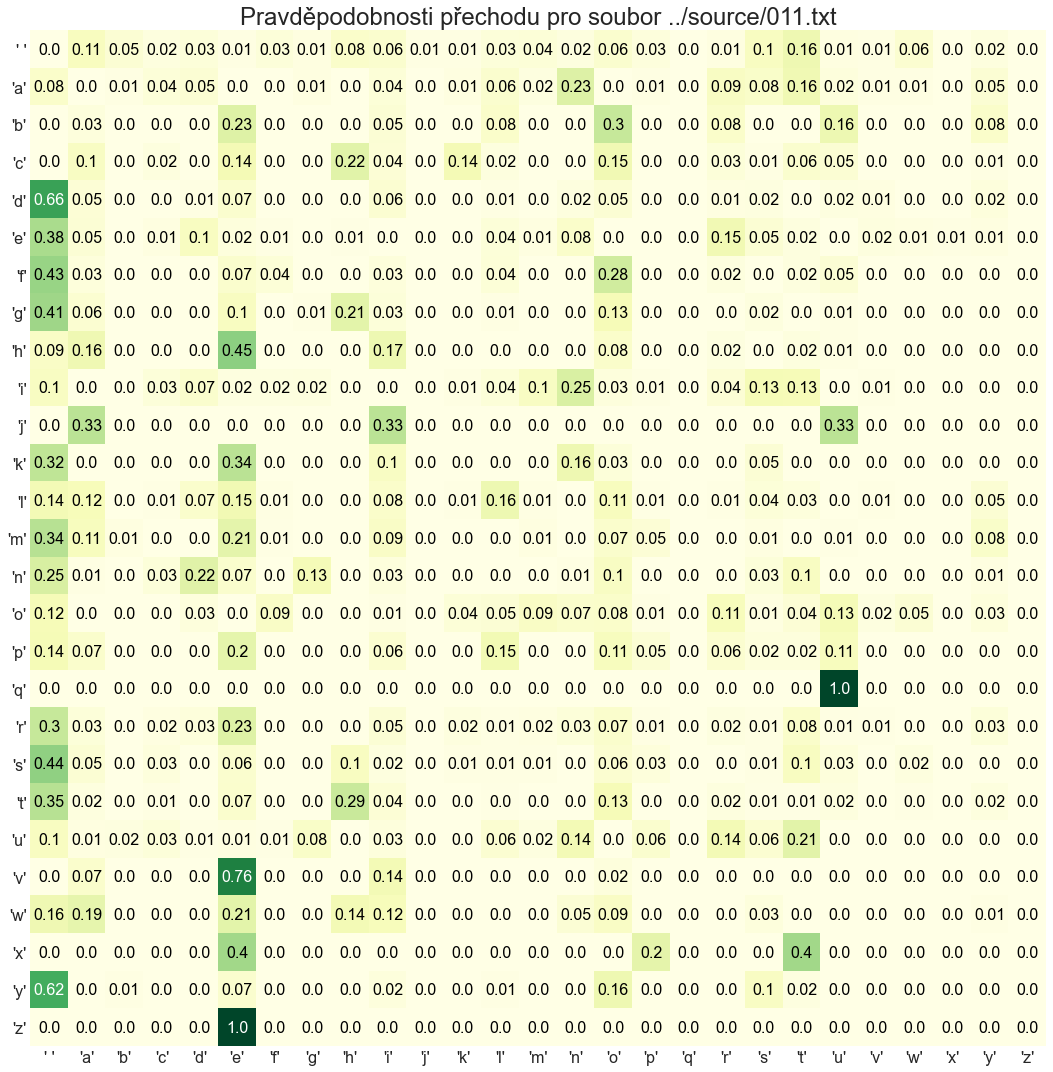

In [24]:
def create_transition_matrix(char_freq: dict):
    trans_mat = []

    for c1, v1 in char_freq.items():
        row = []
        for c2, v2 in v1.items():
            if c2 == 'count':
                continue
            if v1['count'] == 0:
                row.append(0)
                continue
            row.append(v2/v1['count'])
        trans_mat.append(row)
    return trans_mat

def print_heatmap(trans_matrix: list[list], unique_chars: list, f):
    trans_matrix = np.array(trans_matrix)
    fig, ax = plt.subplots()
    ax.imshow(trans_matrix, cmap='YlGn')

    ax.set_xticks(np.arange(len(unique_chars)))
    ax.set_yticks(np.arange(len(unique_chars)))

    ax.set_xticklabels(['\'{}\''.format(c) for c in unique_chars], fontsize=fontsize)
    ax.set_yticklabels(['\'{}\''.format(c) for c in unique_chars], fontsize=fontsize)

    for i in range(len(unique_chars)):
        for j in range(len(unique_chars)):
            if trans_matrix[i, j] > 0.5:
                text_color = 'w'
            else:
                text_color = '0'
            ax.text(j, i, round(trans_matrix[i, j], 2), ha="center", va="center", color=text_color, fontsize=fontsize)

    ax.set_title("Pravděpodobnosti přechodu pro soubor {}".format(f.name), fontsize=fontsize*1.5)
    fig.tight_layout()
    plt.show()


P1 = create_transition_matrix(freq_1)
print_heatmap(P1, unique_chars_1, f1)
# P2 = create_transition_matrix(freq_2)
# print_heatmap(P2, unique_chars_2, f2)

## 2. Na základě matice z předchozího bodu najděte stacionární rozdělení $\boldsymbol{\pi}$ tohoto řetězce pro **první** text.

Pro stacionární rozdělení $\pi$ musí platit následující rovnost:
$$\pi · \mathbf{P} = \pi .$$
(A samozřejmě součet prvků stacionárního rozdělení musí být roven 1 a prvky stacionárního rozdělení musí být nezáporná čísla.)

My jsme pro výpočet stacionárního rozdělní použili funkci *null_space* z knihovny scipy. Tato funkce je určena pro hledání jádra matice a jako tuto matici jsme dosadili $\mathbf{P}^T - \mathbf{I}$, kde $\mathbf{I}$ je jednotková matice. Výsledek je nutné normalizovat a následně opět transponovat.

In [25]:
def get_stationary_distribution(transition_matrix, unique_chars):
    pi = la.null_space(np.transpose(transition_matrix) - np.identity(len(unique_chars)))
    return np.transpose(pi/la.norm(pi, ord=1))[0]

stat_dist_1 = get_stationary_distribution(P1, unique_chars_1)
print('Stacionární rozdělení:\n', stat_dist_1.round(3))

Stacionární rozdělení:
 [0.206 0.059 0.013 0.015 0.039 0.088 0.017 0.014 0.053 0.049 0.002 0.01
 0.032 0.025 0.051 0.072 0.013 0.    0.042 0.049 0.077 0.025 0.007 0.019
 0.001 0.02  0.   ]


## 3. Porovnejte rozdělení znaků druhého textu se stacionárním rozdělením $\boldsymbol{\pi}$, tj. na hladině významnosti 5 % otestujte hypotézu, že rozdělení znaků **druhého** textu se rovná rozdělení $\boldsymbol{\pi}$ z předchozího bodu.

Pro porovnání rozdělení znaků druhého textu se stacionárním rozdělením použijeme test dobré shody, tzn. zda skutečné četnosti znaků druhého textu pochází z daného stacionárního rozdělení.

Hypotézy:
* $H_0:\text{ Skutečné hodnoty pravděpodobností znaků druhého textu odpovídají pravděpodobnostem ze stacionárního rozdělení }\pi.$
* $H_A:\text{ Rozdělení znaků druhého textu je jiné}.$

Použijeme testovou statistiku $\chi^2$, která je definována následujícím vztahem:
$$\chi^2 = \sum\limits_{i=1}^{k}\frac{(N_i - np_i)^2}{np_i}$$

$N$ obsahuje absolutní četnosti znaků druhého textu. Teoretické četnosti, $np_i$, vypočítáme jako stacionární rozdělení vynásobené počtem znaků druhého textu. Pro teoretické četnosti musíme zkontrolovat, že pro každou teoretickou četnost platí, že je $\geq 5$. Pokud tato podmínka neplatí, tak některé sloupce sloučíme, tak aby podmínka byla splněna.

In [27]:
def merge_bins(N, stat_dist_1):
    n = np.sum(N)
    npp = (stat_dist_1 * n).tolist()

    # Merge bins with values < 5
    tmp = [0, 0]
    indexes_to_remove = []
    for i in range(stat_dist_1.size):
        # Check if this column contains value < 5
        if npp[i] < 5:
            # If so, add value of theoretical and real frequencies to tmp variable
            tmp[0] += npp[i]
            tmp[1] += N[i]
            indexes_to_remove.append(i)

            # If added theoretical frequencies are above 5, append them and real freq. to the end of list
            if tmp[0] >= 5:
                npp.append(tmp[0])
                N.append(tmp[1])
                tmp = [0, 0]

    # Delete items with values < 5 from the list
    for index in sorted(indexes_to_remove, reverse=True):
        del npp[index]
        del N[index]

    # Add remaining tmp value to lowest number in list
    min_val_index = npp.index(min(npp))
    npp[min_val_index] += tmp[0]
    N[min_val_index] += tmp[1]

    return N, npp

# Create contingency table
N = [v['count'] for v in freq_2.values()]
N, npp = merge_bins(N, stat_dist_1)

alpha = 0.05
s, p = stats.chisquare(N, npp)

print("p-hodnota:", p)
print("Hypotézu H\N{SUBSCRIPT ZERO} zamítáme na hladině významnosti {}%: {}".format(alpha * 100, alpha >= p))

p-hodnota: 4.12354611458551e-16
Hypotézu H₀ zamítáme na hladině významnosti 5.0%: True
